# The basic model with first-order condition

In [1]:
import sys
import os
sys.path.append(os.path.abspath("..")) 
from dynamic_model.Basic import BasicModel
import tensorflow as tf
from dynamic_model.networks import BellmanNet_FOC
from dynamic_model.trainer import BellmanTrainer

2025-12-31 04:21:04.892549: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-31 04:21:06.280330: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
model = BasicModel(   cost_type = "None")
net = BellmanNet_FOC(model)

Trainer =  BellmanTrainer(model, net, hidden_dim=[32,  32], nu = 10, lr=1e-3)

Trainer.fit(training_steps = 20000, display_step=2000, eval= True,  early_stop = False,  eval_interval=10, n_eval_points = 8192, reward_drop_tolerance = 20)

2025-12-31 04:21:12.351887: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14633 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:61:00.0, compute capability: 7.0
2025-12-31 04:21:12.352709: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14633 MB memory:  -> device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:62:00.0, compute capability: 7.0
2025-12-31 04:21:12.353342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14634 MB memory:  -> device: 2, name: Tesla V100-SXM2-16GB, pci bus id: 0000:89:00.0, compute capability: 7.0
2025-12-31 04:21:12.353959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 14634 MB memory:  -> device: 3, name: Tesla V100-SXM2-16GB, pci bus id

Starting training ...
Network weights initialized.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_curves(logs):

    required_keys = ['loss_history', 'loss_bellman', 'loss_foc']
    missing = [k for k in required_keys if k not in logs]
    if missing:
        raise KeyError(f"缺少必要的key: {missing}")

    best_epoch = logs.get('best_epoch', None)
    overfit_epoch = logs.get('overfit_epoch', None)

    keys = ['loss_history', 'loss_bellman', 'loss_foc']
    titles = ['Total Loss', 'Bellman Residual', 'FOC Residual']
    colors = ['tab:blue', 'tab:orange', 'tab:green']

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for ax, key, title, color in zip(axes, keys, titles, colors):
        values = np.asarray(logs[key])
        steps = np.arange(1, len(values) + 1)

        ymin, ymax = np.min(values), np.max(values)
        pad = 0.05 * (ymax - ymin + 1e-8)
        ax.set_ylim(ymin - pad, ymax + pad)

       
        if best_epoch and best_epoch < len(values):
            ax.plot(steps[:best_epoch], values[:best_epoch], color=color, lw=2, label='Training Loss')
            ax.plot(steps[best_epoch-1:], values[best_epoch-1:], color=color, lw=2, linestyle='--', alpha=0.7)
            ax.axvline(best_epoch, color=color, linestyle=':', lw=1.8, label=f'Best Epoch')
            ax.text(best_epoch, ymin + (ymax - ymin) * 0.9, f"Best", color='red',
                    fontsize=10, ha='center', va='top', fontweight='bold')
        else:
            ax.plot(steps, values, color=color, lw=2, label='Training Loss')

        #if overfit_epoch and overfit_epoch <= len(values):
            #ax.axvline(overfit_epoch, color='purple', linestyle='-.', lw=1.5,)
                       #label=f'Overfit Epoch = {overfit_epoch}')
            #ax.text(overfit_epoch, ymin + (ymax - ymin) * 0.8, f"Overfit\n{overfit_epoch}",
                    #color='purple', fontsize=9, ha='center', va='top', fontweight='bold')

       
        ax.set_title(title, fontsize=13, weight="bold")
        ax.set_xlim(0, len(values))
        ax.set_xlabel("Training Steps", fontsize=11)
        ax.set_ylabel("Loss Value", fontsize=11)
        ax.grid(alpha=0.3)
        ax.legend(fontsize=8, loc='best')

    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_evaluation_curves(logs, max_train_steps=None):
    """
    绘制评估指标变化曲线。
    - Euler Residual
    - Lifetime Reward（含 best_epoch / overfit_epoch 标注）
    
    参数
    ----
    logs : dict
        必须包含以下 key：
        - 'eval_epochs'            : list 或 np.array
        - 'eval_euler_resid'       : list 或 np.array
        - 'eval_lifetime_reward'   : list 或 np.array
        可选：
        - 'best_epoch'             : int
        - 'overfit_epoch'          : int
    max_train_steps : int, 可选
        若提供，则调整横坐标范围与训练步骤对齐。
    """

    required_keys = ['eval_epochs', 'eval_euler_resid', 'eval_lifetime_reward']
    missing = [k for k in required_keys if k not in logs]
    if missing:
        raise KeyError(f"缺少必要的 key: {missing}")

    eval_epochs = np.asarray(logs['eval_epochs'])
    euler_resid = np.asarray(logs['eval_euler_resid'])
    lifetime_reward = np.asarray(logs['eval_lifetime_reward'])

    best_epoch = logs.get('best_epoch', None)
    overfit_epoch = logs.get('overfit_epoch', None)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # ==== 图 1: Euler Residual ====
    ax = axes[0]
    color = 'tab:red'
    ax.plot(eval_epochs, euler_resid, linestyle='solid', color=color, lw=1, label='Euler Residual')
    ax.set_xlabel('Training Steps ', fontsize=12)
    ax.set_ylabel('Euler Residual', fontsize=12,)
    ax.tick_params(axis='y')
    if max_train_steps is not None:
        ax.set_xlim(0, max_train_steps)

    ymin, ymax = np.min(euler_resid), np.max(euler_resid)
    pad = 0.05 * (ymax - ymin + 1e-8)
    ax.set_ylim(ymin - pad, ymax + pad)

    ax.set_title('Euler Residual', fontsize=13, weight='bold')
    ax.grid(alpha=0.3)
    ax.legend()

    # ==== 图 2: Lifetime Reward ====
    ax = axes[1]
    color = 'tab:purple'

    if best_epoch and best_epoch in eval_epochs:
        idx_best = np.where(eval_epochs == best_epoch)[0][0]
    
        ax.plot(eval_epochs[:idx_best+1], lifetime_reward[:idx_best+1],
                linestyle='solid', color=color, lw= 2, label='Reward (pre-best)')
        
        if idx_best < len(eval_epochs) - 1:
            ax.plot(eval_epochs[idx_best:], lifetime_reward[idx_best:], 
                    linestyle='--', color='blue', lw= 2, alpha=0.7, label='Reward (post-best)')
        # 标记 best_epoch
        ax.axvline(best_epoch, color=color, linestyle=':', lw=2)
        ax.text(best_epoch, np.max(lifetime_reward), f"Best",
                color= 'red', fontsize=9, ha='center', va='bottom', fontweight='bold')
    else:
        ax.plot(eval_epochs, lifetime_reward, 's--', color=color, lw=2, label='Lifetime Reward')

    # 标出 overfit_epoch（如果存在）
    #if overfit_epoch and overfit_epoch in eval_epochs:
    #    ax.axvline(overfit_epoch, color='orange', linestyle='-.', lw= 2)
    #    ax.text(overfit_epoch, np.max(lifetime_reward)*0.97,
               # f"Overfit {overfit_epoch}", color='orange', fontsize=9,
               # ha='center', va='top', fontweight='bold')

    ax.set_xlabel('Training Steps', fontsize=12)
    ax.set_ylabel('Lifetime Reward', fontsize=12)
    ax.tick_params(axis='y') #, labelcolor=color)
    if max_train_steps is not None:
        ax.set_xlim(0, max_train_steps)

    ymin, ymax = np.min(lifetime_reward), np.max(lifetime_reward)
    pad = 0.05 * (ymax - ymin + 1e-8)
    ax.set_ylim(ymin - pad, ymax + pad)
    ax.grid(alpha=0.3)
    ax.set_title('Lifetime Reward', fontsize=13, weight='bold')
    ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()
    

In [ ]:
Trainer.fit(training_steps = 20000, display_step=2000, eval= True,  early_stop = False,  eval_interval=10, n_eval_points = 8192, reward_drop_tolerance = 20)

Training progress:   0%|                                                                             | 0/20000 [00:00<?]

Starting training ...
 Network weights initialized.


/home/ztanag/anaconda3/envs/tf_env/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/home/ztanag/anaconda3/envs/tf_env/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Training progress:   0%|                                                                             | 0/20000 [00:02<?]

Epoch     1 | loss_total=1.110664e+06 | loss_V=1.110655e+06 | loss_FOC=9.573937e-01
★ Eval @ epoch 1: lifetime reward = 9.816e+02


Training progress:   1%|▉                                                                      | 250/20000 [00:07<05:57]

⚠️ Overfitting detected at epoch 260. Best reward = 1.2159e+03 (epoch 60)


Training progress:   5%|███▌                                                                   | 999/20000 [00:20<05:03]

Epoch  1000 | loss_total=1.150355e+03 | loss_V=1.149954e+03 | loss_FOC=4.008216e-02
★ Eval @ epoch 1000: lifetime reward = 1.147e+03


Training progress:  10%|██████▉                                                               | 1992/20000 [00:38<05:38]

Epoch  2000 | loss_total=1.019007e+03 | loss_V=1.019006e+03 | loss_FOC=6.504783e-05
★ Eval @ epoch 2000: lifetime reward = -8.659e+02


Training progress:  15%|██████████▍                                                           | 2992/20000 [00:57<05:40]

Epoch  3000 | loss_total=8.692643e+02 | loss_V=8.692599e+02 | loss_FOC=4.272091e-04
★ Eval @ epoch 3000: lifetime reward = -9.771e+05


Training progress:  20%|█████████████▉                                                        | 3990/20000 [01:15<04:41]

Epoch  4000 | loss_total=9.526712e+02 | loss_V=9.526526e+02 | loss_FOC=2.427877e-03
★ Eval @ epoch 4000: lifetime reward = -1.412e+07


Training progress:  25%|█████████████████▍                                                    | 4990/20000 [01:34<04:33]

Epoch  5000 | loss_total=1.145802e+03 | loss_V=1.145662e+03 | loss_FOC=1.394098e-02
★ Eval @ epoch 5000: lifetime reward = -2.479e+12


Training progress:  30%|████████████████████▉                                                 | 5999/20000 [01:52<04:15]

Epoch  6000 | loss_total=1.391700e+03 | loss_V=1.391557e+03 | loss_FOC=2.251386e-02
★ Eval @ epoch 6000: lifetime reward = -1.399e+16


Training progress:  35%|████████████████████████▍                                             | 6992/20000 [02:11<04:25]

Epoch  7000 | loss_total=2.492510e+03 | loss_V=2.492417e+03 | loss_FOC=1.260466e-02
★ Eval @ epoch 7000: lifetime reward = -2.688e+12


Training progress:  40%|███████████████████████████▉                                          | 7990/20000 [02:31<03:47]

Epoch  8000 | loss_total=7.955632e+02 | loss_V=7.954875e+02 | loss_FOC=7.558324e-03
★ Eval @ epoch 8000: lifetime reward = -2.150e+11


Training progress:  45%|███████████████████████████████▍                                      | 8990/20000 [02:50<03:27]

Epoch  9000 | loss_total=9.587993e+02 | loss_V=9.586151e+02 | loss_FOC=1.841946e-02
★ Eval @ epoch 9000: lifetime reward = -6.190e+13


Training progress:  50%|██████████████████████████████████▉                                   | 9990/20000 [03:08<03:03]

Epoch 10000 | loss_total=9.021860e+02 | loss_V=9.020276e+02 | loss_FOC=1.584257e-02
★ Eval @ epoch 10000: lifetime reward = -8.811e+12


Training progress:  55%|█████████████████████████████████████▉                               | 10990/20000 [03:26<02:45]

Epoch 11000 | loss_total=1.558636e+03 | loss_V=1.558704e+03 | loss_FOC=1.372670e-02
★ Eval @ epoch 11000: lifetime reward = -3.519e+13


Training progress:  60%|█████████████████████████████████████████▍                           | 11993/20000 [03:44<02:25]

Epoch 12000 | loss_total=8.593845e+02 | loss_V=8.592607e+02 | loss_FOC=1.238028e-02
★ Eval @ epoch 12000: lifetime reward = -2.106e+12


Training progress:  65%|████████████████████████████████████████████▊                        | 12990/20000 [04:03<02:05]

Epoch 13000 | loss_total=6.692576e+02 | loss_V=6.690443e+02 | loss_FOC=2.659238e-02
★ Eval @ epoch 13000: lifetime reward = -1.048e+17


Training progress:  70%|████████████████████████████████████████████████▎                    | 13999/20000 [04:21<01:37]

Epoch 14000 | loss_total=6.936869e+02 | loss_V=6.935546e+02 | loss_FOC=1.773417e-02
★ Eval @ epoch 14000: lifetime reward = -1.243e+14


Training progress:  75%|███████████████████████████████████████████████████▋                 | 14990/20000 [04:40<01:30]

Epoch 15000 | loss_total=1.339608e+03 | loss_V=1.339448e+03 | loss_FOC=1.602523e-02
★ Eval @ epoch 15000: lifetime reward = -5.528e+13


Training progress:  80%|███████████████████████████████████████████████████████▏             | 15990/20000 [04:59<01:11]

Epoch 16000 | loss_total=4.322540e+02 | loss_V=4.319916e+02 | loss_FOC=2.688352e-02
★ Eval @ epoch 16000: lifetime reward = -4.830e+16


Training progress:  85%|██████████████████████████████████████████████████████████▋          | 16996/20000 [05:17<00:55]

Epoch 17000 | loss_total=6.615787e+02 | loss_V=6.612125e+02 | loss_FOC=3.661853e-02
★ Eval @ epoch 17000: lifetime reward = -7.825e+17


Training progress:  90%|██████████████████████████████████████████████████████████████       | 17990/20000 [05:35<00:36]

Epoch 18000 | loss_total=4.149579e+02 | loss_V=4.148207e+02 | loss_FOC=2.272997e-02
★ Eval @ epoch 18000: lifetime reward = -3.288e+15


Training progress:  91%|██████████████████████████████████████████████████████████████▌      | 18129/20000 [05:37<00:34]


KeyboardInterrupt: 

In [ ]:
Trainer.__dict__.keys()

dict_keys(['model', 'net', 'nu', 'batch_size', 'opt', 'lr', 'test_data', 'train_data', 'training_steps', 'eval_epochs', 'eval_euler_resid', 'eval_lifetime_reward', 'best_reward', 'best_epoch', 'best_weights', 'overfit_epoch', 'overfitting_detected', 'loss_history', 'loss_bellman', 'loss_foc'])

# Plotting

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_curves(logs):

    required_keys = ['loss_history', 'loss_bellman', 'loss_foc']
    missing = [k for k in required_keys if k not in logs]
    if missing:
        raise KeyError(f"缺少必要的key: {missing}")

    best_epoch = logs.get('best_epoch', None)
    overfit_epoch = logs.get('overfit_epoch', None)

    keys = ['loss_history', 'loss_bellman', 'loss_foc']
    titles = ['Total Loss', 'Bellman Residual', 'FOC Residual']
    colors = ['tab:blue', 'tab:orange', 'tab:green']

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for ax, key, title, color in zip(axes, keys, titles, colors):
        values = np.asarray(logs[key])
        steps = np.arange(1, len(values) + 1)

        ymin, ymax = np.min(values), np.max(values)
        pad = 0.05 * (ymax - ymin + 1e-8)
        ax.set_ylim(ymin - pad, ymax + pad)

       
        if best_epoch and best_epoch < len(values):
            ax.plot(steps[:best_epoch], values[:best_epoch], color=color, lw=2, label='Training Loss')
            ax.plot(steps[best_epoch-1:], values[best_epoch-1:], color=color, lw=2, linestyle='--', alpha=0.7)
            ax.axvline(best_epoch, color=color, linestyle=':', lw=1.8, label=f'Best Epoch')
            ax.text(best_epoch, ymin + (ymax - ymin) * 0.9, f"Best", color='red',
                    fontsize=10, ha='center', va='top', fontweight='bold')
        else:
            ax.plot(steps, values, color=color, lw=2, label='Training Loss')

        #if overfit_epoch and overfit_epoch <= len(values):
            #ax.axvline(overfit_epoch, color='purple', linestyle='-.', lw=1.5,)
                       #label=f'Overfit Epoch = {overfit_epoch}')
            #ax.text(overfit_epoch, ymin + (ymax - ymin) * 0.8, f"Overfit\n{overfit_epoch}",
                    #color='purple', fontsize=9, ha='center', va='top', fontweight='bold')

       
        ax.set_title(title, fontsize=13, weight="bold")
        ax.set_xlim(0, len(values))
        ax.set_xlabel("Training Steps", fontsize=11)
        ax.set_ylabel("Loss Value", fontsize=11)
        ax.grid(alpha=0.3)
        ax.legend(fontsize=8, loc='best')

    plt.tight_layout()
    plt.show()

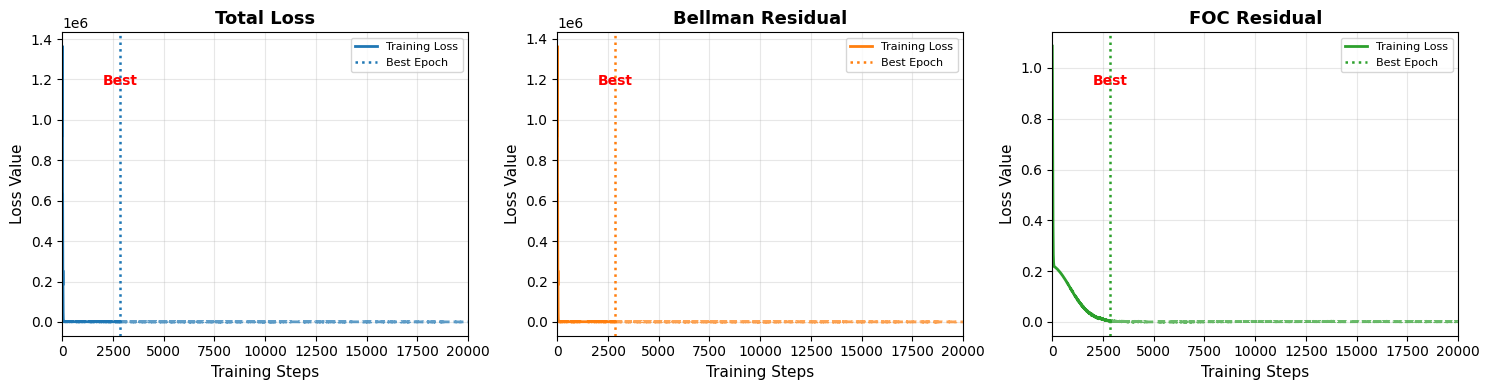

In [ ]:

plot_training_curves(Trainer.__dict__)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_evaluation_curves(logs, max_train_steps=None):
    """
    绘制评估指标的变化曲线（Euler Residual 和 Lifetime Reward 分成两张图）。
    
    参数
    ----
    logs : dict
        必须包含以下 key：
        - 'eval_epochs'            : list 或 np.array
        - 'eval_euler_resid'       : list 或 np.array
        - 'eval_lifetime_reward'   : list 或 np.array
    max_train_steps : int, 可选
        若提供，则调整横坐标范围与训练步骤对齐。
    """
    required_keys = ['eval_epochs', 'eval_euler_resid', 'eval_lifetime_reward']
    missing = [k for k in required_keys if k not in logs]
    if missing:
        raise KeyError(f"缺少必要的 key: {missing}")

    eval_epochs = np.asarray(logs['eval_epochs'])
    euler_resid = np.asarray(logs['eval_euler_resid'])
    lifetime_reward = np.asarray(logs['eval_lifetime_reward'])

    # 一行两列的子图
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # ------- 图1: Euler Residual -------
    ax = axes[0]
    color = 'tab:red'
    ax.plot(eval_epochs, euler_resid, 'o-', color=color, lw=2, label='Euler Residual')
    ax.set_xlabel('Training Steps (Eval Points)', fontsize=12)
    ax.set_ylabel('Euler Residual', fontsize=12)
    ax.tick_params(axis='y', labelcolor=color)
    if max_train_steps is not None:
        ax.set_xlim(0, max_train_steps)

    # 自动纵轴范围
    ymin, ymax = np.min(euler_resid), np.max(euler_resid)
    pad = 0.05 * (ymax - ymin + 1e-8)
    ax.set_ylim(ymin - pad, ymax + pad)

    ax.set_title('Euler Residual ', fontsize=13, weight='bold')
    ax.grid(alpha=0.3)
    ax.legend()

    # ------- 图2: Lifetime Reward -------
    ax = axes[1]
    color = 'tab:purple'
    ax.plot(eval_epochs, lifetime_reward, 's--', color=color, lw=2, label='Lifetime Reward')
    ax.set_xlabel('Training Steps (Eval Points)', fontsize=12)
    ax.set_ylabel('Lifetime Reward', fontsize=12, color=color)
    ax.tick_params(axis='y', labelcolor=color)
    if max_train_steps is not None:
        ax.set_xlim(0, max_train_steps)

    ymin, ymax = np.min(lifetime_reward), np.max(lifetime_reward)
    pad = 0.05 * (ymax - ymin + 1e-8)
    ax.set_ylim(ymin - pad, ymax + pad)

    ax.set_title('Lifetime Reward', fontsize=13, weight='bold')
    ax.grid(alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_evaluation_curves(logs, max_train_steps=None):
    """
    绘制评估指标变化曲线。
    - Euler Residual
    - Lifetime Reward（含 best_epoch / overfit_epoch 标注）
    
    参数
    ----
    logs : dict
        必须包含以下 key：
        - 'eval_epochs'            : list 或 np.array
        - 'eval_euler_resid'       : list 或 np.array
        - 'eval_lifetime_reward'   : list 或 np.array
        可选：
        - 'best_epoch'             : int
        - 'overfit_epoch'          : int
    max_train_steps : int, 可选
        若提供，则调整横坐标范围与训练步骤对齐。
    """

    required_keys = ['eval_epochs', 'eval_euler_resid', 'eval_lifetime_reward']
    missing = [k for k in required_keys if k not in logs]
    if missing:
        raise KeyError(f"缺少必要的 key: {missing}")

    eval_epochs = np.asarray(logs['eval_epochs'])
    euler_resid = np.asarray(logs['eval_euler_resid'])
    lifetime_reward = np.asarray(logs['eval_lifetime_reward'])

    best_epoch = logs.get('best_epoch', None)
    overfit_epoch = logs.get('overfit_epoch', None)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # ==== 图 1: Euler Residual ====
    ax = axes[0]
    color = 'tab:red'
    ax.plot(eval_epochs, euler_resid, linestyle='solid', color=color, lw=1, label='Euler Residual')
    ax.set_xlabel('Training Steps ', fontsize=12)
    ax.set_ylabel('Euler Residual', fontsize=12,)
    ax.tick_params(axis='y')
    if max_train_steps is not None:
        ax.set_xlim(0, max_train_steps)

    ymin, ymax = np.min(euler_resid), np.max(euler_resid)
    pad = 0.05 * (ymax - ymin + 1e-8)
    ax.set_ylim(ymin - pad, ymax + pad)

    ax.set_title('Euler Residual', fontsize=13, weight='bold')
    ax.grid(alpha=0.3)
    ax.legend()

    # ==== 图 2: Lifetime Reward ====
    ax = axes[1]
    color = 'tab:purple'

    if best_epoch and best_epoch in eval_epochs:
        idx_best = np.where(eval_epochs == best_epoch)[0][0]
    
        ax.plot(eval_epochs[:idx_best+1], lifetime_reward[:idx_best+1],
                linestyle='solid', color=color, lw= 2, label='Reward (pre-best)')
        
        if idx_best < len(eval_epochs) - 1:
            ax.plot(eval_epochs[idx_best:], lifetime_reward[idx_best:], 
                    linestyle='--', color='blue', lw= 2, alpha=0.7, label='Reward (post-best)')
        # 标记 best_epoch
        ax.axvline(best_epoch, color=color, linestyle=':', lw=2)
        ax.text(best_epoch, np.max(lifetime_reward), f"Best",
                color= 'red', fontsize=9, ha='center', va='bottom', fontweight='bold')
    else:
        ax.plot(eval_epochs, lifetime_reward, 's--', color=color, lw=2, label='Lifetime Reward')

    # 标出 overfit_epoch（如果存在）
    #if overfit_epoch and overfit_epoch in eval_epochs:
    #    ax.axvline(overfit_epoch, color='orange', linestyle='-.', lw= 2)
    #    ax.text(overfit_epoch, np.max(lifetime_reward)*0.97,
               # f"Overfit {overfit_epoch}", color='orange', fontsize=9,
               # ha='center', va='top', fontweight='bold')

    ax.set_xlabel('Training Steps', fontsize=12)
    ax.set_ylabel('Lifetime Reward', fontsize=12)
    ax.tick_params(axis='y') #, labelcolor=color)
    if max_train_steps is not None:
        ax.set_xlim(0, max_train_steps)

    ymin, ymax = np.min(lifetime_reward), np.max(lifetime_reward)
    pad = 0.05 * (ymax - ymin + 1e-8)
    ax.set_ylim(ymin - pad, ymax + pad)
    ax.grid(alpha=0.3)
    ax.set_title('Lifetime Reward', fontsize=13, weight='bold')
    ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

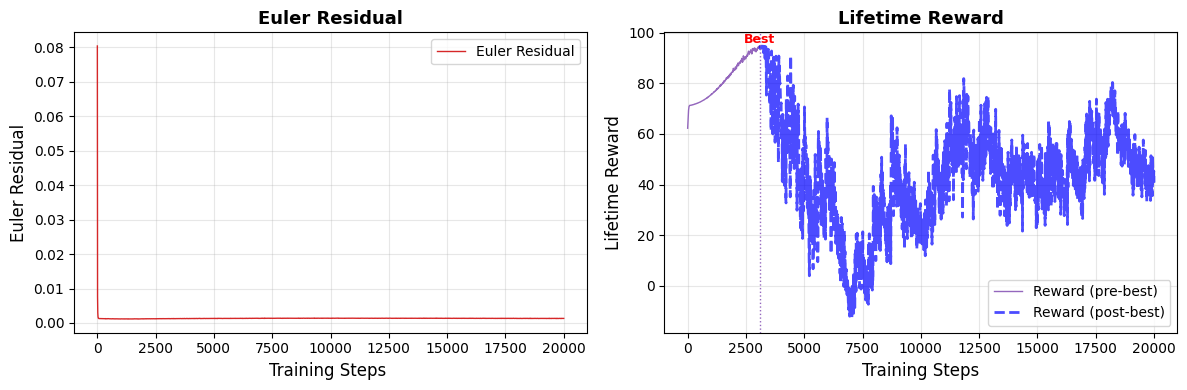

In [ ]:
plot_evaluation_curves(Trainer.__dict__)